# Regional Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm # Logaritmische verdeling
import mplcursors # hooverfunctionaliteit

In [2]:
## Geodataframe Belgie gemeenten
belgium = gpd.read_file('../resources/geodata/kontur_boundaries_BE_20230628.gpkg')
# belgium[(belgium['name'].str.contains('elewijt', case=False) | belgium['name'].str.contains('zemst', case=False))].head()
belgium_gemeenten = belgium[(belgium["osm_admin_level"] == '8')].copy()
belgium_gemeenten.head(5)

,admin_level,osm_admin_level,name,name_en,population,hasc,geometry
55,9,8,Tenneville,None,2861.0,None,"MULTIPOLYGON (((5.39024 50.07851, 5.39032 50.0..."
56,9,8,Rendeux,None,2596.0,None,"MULTIPOLYGON (((5.44198 50.22504, 5.44237 50.2..."
57,9,8,Boechout,None,12318.0,None,"MULTIPOLYGON (((4.47911 51.16276, 4.47986 51.1..."
58,9,8,Ville de Bruxelles - Stad Brussel,Brussels,220447.0,None,"MULTIPOLYGON (((4.314 50.8934, 4.318 50.89451,..."
59,9,8,Spiere-Helkijn,None,1939.0,None,"MULTIPOLYGON (((3.32376 50.72324, 3.32429 50.7..."


In [3]:
## Geodataframe waarnemingen halsbandparkiet en boomklever
halsbandparkiet = f'../3_scaling/scaled_data/observations_halsbandparkiet_scaled.parquet'
boomklever = f'../3_scaling/scaled_data/observations_boomklever_scaled.parquet'

# Load the data from 2024
df_halsbandparkiet = pd.read_parquet(halsbandparkiet, engine="pyarrow")
df_halsbandparkiet_2024 = df_halsbandparkiet[df_halsbandparkiet['year']==2024].copy()
geometry_hp = gpd.points_from_xy(df_halsbandparkiet_2024['longitude'], df_halsbandparkiet_2024['latitude'])
gpd_hp_2024 = gpd.GeoDataFrame(df_halsbandparkiet_2024, geometry=geometry_hp, crs="EPSG:4326")

df_boomklever = pd.read_parquet(boomklever, engine="pyarrow")
df_boomklever_2024 = df_boomklever[df_boomklever['year']==2024].copy()
geometry_bk = gpd.points_from_xy(df_boomklever_2024['longitude'], df_boomklever_2024['latitude'])
gpd_bk_2024 = gpd.GeoDataFrame(df_boomklever_2024, geometry=geometry_bk, crs="EPSG:4326")

# Stap 4: Voer een ruimtelijke join uit om waarnemingen te koppelen aan gemeenten
gdf_merged_hp = gpd.sjoin(gpd_hp_2024, belgium_gemeenten, how="right", predicate="within")
# gdf_merged_all = gpd.sjoin(gpd_bk_2024, gdf_merged_hp, how="right", predicate="within")

# Stap 5: Tel het aantal waarnemingen per gemeente (TODO, slechts 1 observatie toelaten per observer? -> dan klopt wel onze scaled data feitelijk niet meer -> enkel met absolute waarden?)
hp_per_gemeente = gdf_merged_hp.groupby("name").agg({'observation_count_sc': 'sum', 'observer_id': 'nunique'}).reset_index()
hp_per_gemeente.head()

# Stap 2: Voeg geometrie terug toe vanuit het oorspronkelijke gemeenten-GeoDataFrame
hp_per_gemeente = hp_per_gemeente.merge(
    belgium_gemeenten[['name', 'geometry']], on='name', how='left'
)

# Stap 3: Zorg dat het een GeoDataFrame blijft
hp_per_gemeente = gpd.GeoDataFrame(hp_per_gemeente, geometry='geometry', crs="EPSG:4326")

# Bekijk het resultaat
hp_per_gemeente.head()

,name,observation_count_sc,observer_id,geometry
0,Aalst,21.406322,27,"MULTIPOLYGON (((3.98245 50.91942, 3.98282 50.9..."
1,Aalter,0.305805,1,"MULTIPOLYGON (((3.33131 51.09888, 3.33256 51.0..."
2,Aarschot,0.000000,0,"MULTIPOLYGON (((4.77398 50.97824, 4.7744 50.97..."
3,Aartselaar,2.140632,5,"MULTIPOLYGON (((4.35371 51.11358, 4.35371 51.1..."
4,Affligem,4.892874,8,"MULTIPOLYGON (((4.0743 50.89938, 4.07527 50.89..."


EPSG:3857


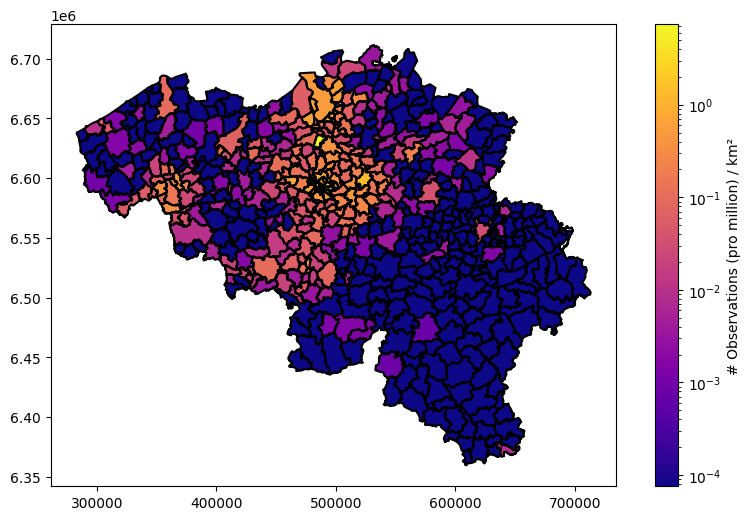

In [ ]:
#  plot defineren
fig, ax = plt.subplots(figsize=(10, 6))

print(hp_per_gemeente.crs)
hp_per_gemeente = hp_per_gemeente.to_crs(epsg=3857)

hp_per_gemeente.boundary.plot(color='black', ax=ax) #  boundaries, kan je standaard ophalen omdat we geometry hebben
hp_per_gemeente["area"]= hp_per_gemeente.area/1_000_000
hp_per_gemeente["obs_km2"]= hp_per_gemeente["observation_count_sc"]/hp_per_gemeente["area"]

# Voorkom problemen met log(0)
hp_per_gemeente["obs_km2"] = hp_per_gemeente["obs_km2"].replace(0, np.nan)  # Vermijd log(0)
hp_per_gemeente["obs_km2"] = hp_per_gemeente["obs_km2"].fillna(hp_per_gemeente["obs_km2"].min() / 10)

norm = LogNorm(vmin=hp_per_gemeente["obs_km2"].min(), vmax=hp_per_gemeente["obs_km2"].max()) # logaritmische verdeling
# norm = plt.Normalize(vmin=hp_per_gemeente["obs_km2"].min(), vmax=hp_per_gemeente["obs_km2"].max()) # te weinig verschil

hp_per_gemeente.plot(column="obs_km2", cmap="plasma", legend = True, ax=ax, norm = norm)
cbar = ax.get_figure().axes[-1]  # The last axis is usually the colorbar
cbar.set_ylabel("# Observations (pro million) / km²")

# Toon de plot
plt.show()

https://chatgpt.com/c/67e91367-e2b4-8012-b7b8-821ef6151c28